#### Imports and settings

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import randint
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


#### Customize IDE

In [83]:
# IDE theme
!jt -t chesterish -f roboto -fs 9 -nfs 11

In [84]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

#### Load datasets

In [85]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test_labels = pd.read_csv('../input/test_labels.csv')

#### Check for nulls in datasets

In [86]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [87]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

#### Datasets overview

In [88]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [89]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train*100/(n_train+n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test*100/(n_train+n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [90]:
classes_train = train.iloc[:,2:]
classes_sums = classes_train.sum(axis=1)
train["clean"] = (classes_sums == 0)
n_clean_samples = train["clean"].sum()

In [91]:
print("Total comments: ", len(train))
print("Clean: ", n_clean_samples)
print("Dirty: ", len(train) - n_clean_samples)
print("Sums of classes: ")
print(classes_train.sum())

Total comments:  159571
Clean:  143346
Dirty:  16225
Sums of classes: 
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


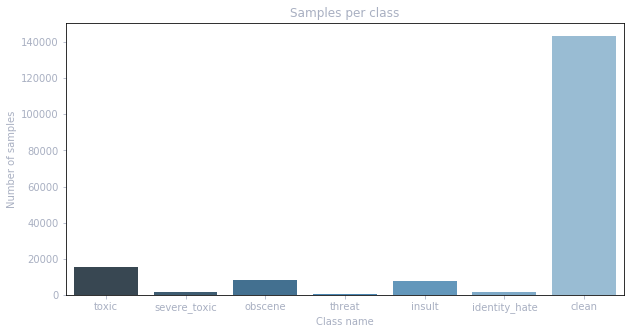

In [92]:
# extended by 'clean' column
classes_extended_sums = train.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(classes_extended_sums.index, classes_extended_sums.values, palette="Blues_d")
plt.show()

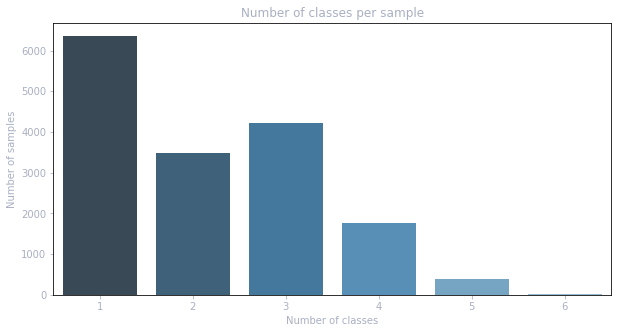

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [93]:
# without '0 classes'
multiple_classes = classes_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes.index, multiple_classes.values, palette="Blues_d")
plt.show()
print(multiple_classes)

#### Example samples

In [94]:
min_samples_in_class = classes_train.sum().min() - 1

toxic_samples = train[train.toxic == 1]
severe_toxic_samples = train[train.severe_toxic == 1]
obscene_samples = train[train.obscene == 1]
threat_samples = train[train.threat == 1]
insult_samples = train[train.insult == 1]
identity_hate_samples = train[train.identity_hate == 1]
clean_samples = train[train.clean == 1]

print("Toxic:\n")
print(toxic_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Severe toxic:\n")
print(severe_toxic_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Obscene:\n")
print(obscene_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Threat:\n")
print(threat_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Insult:\n")
print(insult_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Identity hate:\n")
print(identity_hate_samples.iloc[randint(0, min_samples_in_class),1], "\n")
print("Clean:\n")
print(clean_samples.iloc[randint(0, min_samples_in_class),1], "\n")

Toxic:

Yeah! You dummy!  Bakutrix 

Severe toxic:

Would you like to eat my shit? 

Obscene:

User:Abd is Muslim scum 

Threat:

Graeme Bartlet MUST die 

Insult:

Wikipedia editors and their homosexual nature  

Hi im the Master Editor all changes that I make are final and completely finite any attempt to applicate a change will result in immediate expulsion from Wikipedia and your XBOX's will be turned off for a week. This one goes out to all you Wikipedia editors who have yet to find a life and or a purpse keep on trucking. 

Identity hate:

I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms 

Clean:

, 16 December 2005 (UTC)
Mendel doesn't talk about those changes at all.  Mendel was refering to the Conspiracy section that used to be there.  16:53 



#### Wordclouds

In [95]:
stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))

wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

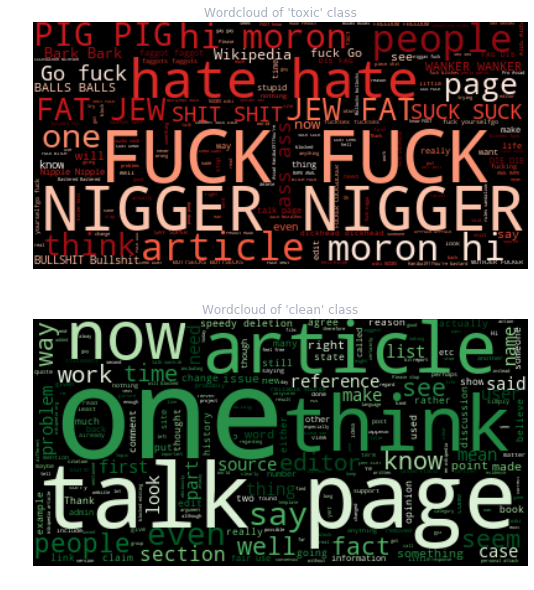

In [96]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Feature engineering

In [97]:
whole_dataset = pd.concat([train.iloc[:,0:2], train.iloc[:,0:2]]).reset_index(drop=True)

In [98]:
whole_dataset

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ..."
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...
9,00040093b2687caa,alignment on this subject and which are contra...


#### <b><font color="green">TODO:</font></b> Finish 'Feature engineering' section (e.g. correlation between features)

### Tokenization of comments

In [127]:
import sys, os, re, csv, codecs
import operator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [100]:
# Get original training dataset
train.drop("clean", axis=1, inplace=True)

In [101]:
classes = train.columns.values[2:]

In [102]:
labeling_train = train[classes].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

#### <b><font color="green">TODO:</font></b> Experimentalize with 'max_n_words' values

In [141]:
max_n_words = 25000
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(list(comments_train))

In [142]:
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [143]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

In [145]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

In [146]:
# tokenized comment
tokenized_sequences_train[0]

[688,
 75,
 1,
 126,
 130,
 177,
 29,
 672,
 4511,
 12052,
 1116,
 86,
 331,
 51,
 2278,
 11448,
 50,
 6864,
 15,
 60,
 2756,
 148,
 7,
 2937,
 34,
 117,
 1221,
 15190,
 2825,
 4,
 45,
 59,
 244,
 1,
 365,
 31,
 1,
 38,
 27,
 143,
 73,
 3462,
 89,
 3085,
 4583,
 2273,
 985]

#### <b><font color="green">TODO:</font></b> Experimentalize with 'maxlen' values

In [157]:
fixed_len = 200
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=fixed_len)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=fixed_len)

In [161]:
print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('After padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]
After padding: ( 200 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    

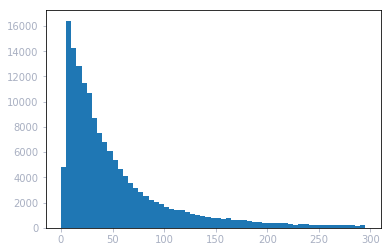

In [166]:
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

### Building the model